# Tie contact 3d

Author(s): Jukka Aho

## Solid block

Geometry and mesh:

<div class="main_block" style="max-width: 800px;">
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-box_geom.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-box_bcs.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
</div>

In [1]:
using JuliaFEM
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: LinearElasticityProblem, DirichletProblem, get_connectivity, Quad4, Hex8, DirectSolver

In [2]:
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/mesh.med")
#mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/twoelem_box.med")

INFO: Found 4 element sets: SYM23, SYM12, SYM13, LOAD


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(2=>[0.0,0.0,0.0],11=>[0.0,0.3333333333333333,1.0],39=>…
  "connectivity" => Dict(68=>(:QU4,:OTHER,[45,47,48,46]),2=>(:SE2,:OTHER,[9,10]…

In [5]:
# interior elements are of type HE8
field_problem = LinearElasticityProblem()
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :HE8 || continue
    element = Hex8(elcon)
    element["geometry"] = Vector{Float64}[mesh["nodes"][i] for i in get_connectivity(element)]
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    push!(field_problem, element)
end
# Neumann boundary condition, traction force -100 on Z direction for element set LOAD
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == :LOAD) || continue
    element = Quad4(elcon)
    element["geometry"] = Vector{Float64}[mesh["nodes"][i] for i in get_connectivity(element)]
    element["displacement traction force"] = Vector{Float64}[[0.0, 0.0, -100.0] for i=1:4]
    push!(field_problem, element)
end
info("created $(length(field_problem.elements)) elements.")

INFO: created 36 elements.


In [6]:
# boundary conditions
boundary_problem = DirichletProblem("displacement", 3)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset in [:SYM23, :SYM12, :SYM13]) || continue
    element = Quad4(elcon)
    element["geometry"] = Vector{Float64}[mesh["nodes"][i] for i in get_connectivity(element)]
    if elset == :SYM23
        element["displacement 1"] = 0.0
    elseif elset == :SYM12
        element["displacement 3"] = 0.0
    elseif elset == :SYM13
        element["displacement 2"] = 0.0
    end
    push!(boundary_problem, element)
end
info("created $(length(boundary_problem.elements)) boundary elements.")

INFO: created 27 boundary elements.


In [7]:
solver = DirectSolver()
solver.name = "block"
solver.nonlinear_problem = false
#solver.method = :UMFPACK
solver.dump_matrices = true
push!(solver, field_problem)
push!(solver, boundary_problem)
call(solver, 0.0)

INFO: # of field problems: 1
INFO: # of boundary problems: 1
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1...
INFO: dim = 192
INFO: Assembling boundary problems...
INFO: Assembling boundary 1...
INFO: dumping matrices to disk, file = matrices_block_host_1_iteration_1.jld
INFO: Solving system
INFO: CHOLMOD: all dofs = 192
INFO: CHOLMOD: interior dofs = 144
INFO: CHOLMOD: boundary dofs = 48
INFO: CHOLMOD: displacement on boundary solved.
INFO: CHOLMOD: homogeneous dirichlet boundary
INFO: CHOLMOD: LDLt factorization done in 0.0012049674987792969 seconds
INFO: CHOLMOD: solved in 0.05479288101196289 seconds. norm = 0.5879447357921324
INFO: timing info for iteration:
INFO: boundary assembly       : 0.09608697891235352


(1,true)

INFO: field assembly          : 1.0157549381256104
INFO: dump matrices to disk   : 0.9569120407104492
INFO: solve problem           : 0.48387885093688965
INFO: update element data     : 0.01578807830810547
INFO: non-linear iteration    : 2.568441867828369
INFO: solver finished in 2.7200798988342285 seconds.


In [8]:
nid = 0
for (nid, coords) in mesh["nodes"]
    if isapprox(coords, [1.0, 1.0, 1.0])
        info("nid near corner = $nid")
        break
    end
end
nid

INFO: nid near corner = 7


7

In [9]:
using JuliaFEM.Test
known_value = [1/36, 1/36, -1/9]
for element in field_problem.elements
    i = indexin([nid], get_connectivity(element))[1]
    i != 0 || continue
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    info("displacement X = $(X[i]), u = $(u[i])")
    @test isapprox(u[i], known_value)
end

INFO: displacement X = [1.0,1.0,1.0], u = [0.027777777777777794,0.02777777777777784,-0.11111111111111129]
INFO: displacement X = [1.0,1.0,1.0], u = [0.027777777777777794,0.02777777777777784,-0.11111111111111129]


In [10]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []
for el in field_problem.elements
    isa(el, JuliaFEM.Core.Element{JuliaFEM.Core.Hex8}) || continue
    push!(elements, (:Hex8, get_connectivity(el)))
end
#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/foobar2.xmf");

INFO: XDFM: ndim = 192


<img src="http://results.juliafem.org/2015-12-13-box_results.png" width=300px style="float:left">

## Block divived to two parts

Block is now divided to two parts and meshes are tied using mortar method.

<div class="main_block" style="max-width: 800px;">
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-13-divided-block-geometry.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
  <div class="inner_block" style="display: inline-block; float:left; width:50%;">
    <img src="http://results.juliafem.org/2015-12-17-divided-block-both-parts.png"
         style="width:100%; height:auto; vertical-align:middle;">
  </div>
</div>

In [1]:
using JuliaFEM
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: LinearElasticityProblem, DirichletProblem, get_connectivity,
                     Quad4, Hex8, LinearSolver, update
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCKS.med")

INFO: Found 6 element sets: SYM23, SYM12, UPPER_TO_LOWER, LOAD, SYM13, LOWER_TO_UPPER


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(11=>[1.0,0.0,0.5],134=>[0.5,0.25,1.0],158=>[1.0,0.5,0.…
  "connectivity" => Dict(288=>(:HE8,:OTHER,[176,177,180,179,167,168,171,170]),3…

In [2]:
# interior elements are of type HE8
field_problem = LinearElasticityProblem()

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :HE8 || continue
    element = Hex8(elcon)
    update(element, "geometry", mesh["nodes"])
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    #info("lower: add element with connectivity $elcon")
    push!(field_problem, element)
end

# Neumann boundary condition, traction force -100 on Z direction for element set LOAD
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == :LOAD) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    element["displacement traction force 3"] = -100.0
    push!(field_problem, element)
end
info("created $(length(field_problem.elements)) elements.")

# boundary conditions
boundary_problem = DirichletProblem("displacement", 3)

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset in [:SYM23, :SYM12, :SYM13]) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    if elset == :SYM23
        element["displacement 1"] = 0.0
    elseif elset == :SYM12
        element["displacement 3"] = 0.0
    elseif elset == :SYM13
        element["displacement 2"] = 0.0
    end
    push!(boundary_problem, element)
end
info("created $(length(boundary_problem.elements)) boundary elements.")

INFO: created 107 elements.
INFO: created 59 boundary elements.


### Creating tie contact
- define slave element surface (the one where integration happend)
- define potential master elements for slave elements

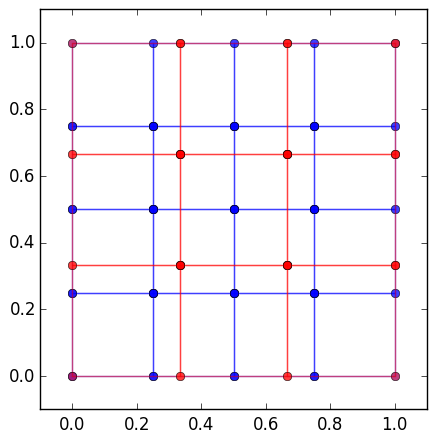

(-0.1,1.1)

In [3]:
using JuliaFEM.Core: Element, MortarProblem, calculate_normal_tangential_coordinates!

using PyPlot

#mortar_surface = :LOWER_TO_UPPER
#slave_surface = :UPPER_TO_LOWER
mortar_surface = :UPPER_TO_LOWER
slave_surface = :LOWER_TO_UPPER

fig1 = figure(figsize=(5, 5))
master_elements = JuliaFEM.Core.Element[]
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == mortar_surface) || continue
    element = Quad4(elcon)
    update(element, "geometry", mesh["nodes"])
    X = element("geometry", 0.0)
    x = [X[mod(i, 4)+1][1] for i=1:5]
    y = [X[mod(i, 4)+1][2] for i=1:5]
    plot(x, y, "-bo", alpha=0.5)
    push!(master_elements, element)
end

contact_problem = MortarProblem("displacement", 3)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :QU4) && (elset == slave_surface) || continue
    element = Quad4(reverse(elcon))
    update(element, "geometry", mesh["nodes"])
    element["master elements"] = master_elements
    X = element("geometry", 0.0)
    x = [X[mod(i, 4)+1][1] for i=1:5]
    y = [X[mod(i, 4)+1][2] for i=1:5]
    plot(x, y, "-ro", alpha=0.5)
    calculate_normal_tangential_coordinates!(element, 0.0)
    push!(contact_problem, element)
end
xlim(-0.1, 1.1)
ylim(-0.1, 1.1)

In [4]:
using JuliaFEM.Core: DirectSolver
solver = DirectSolver()
solver.name = "tie_contact_3d"
solver.method = :UMFPACK
solver.nonlinear_problem = false
solver.max_iterations = 1
solver.dump_matrices = true
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, contact_problem)
call(solver, 0.0)

using JuliaFEM.Test

nid = 0
for (nid, coords) in mesh["nodes"]
    if isapprox(coords, [1.0, 1.0, 1.0])
        info("nid near corner = $nid")
        break
    end
end
nid

known_value = [1/36, 1/36, -1/9]

for element in field_problem.elements
    i = indexin([nid], get_connectivity(element))[1]
    i != 0 || continue
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    info("displacement X = $(X[i]), u = $(u[i])")
    @test isapprox(u[i], known_value)
end

INFO: # of field problems: 1
INFO: # of boundary problems: 2
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1...
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: dim = 567
INFO: Assembling boundary problems...
INFO: Assembling boundary 1...
INFO: Assembling boundary 2...
INFO: dumping matrices to disk, file = matrices_tie_contact_3d_host_1_iteration_1.jld
INFO: Solving system
INFO: UMFPACK: solved in 0.21409296989440918 seconds. norm = 1.0506403593090503
INFO: timing info for iteration:
INFO: boundary assembly       : 1.9287428855895996
INFO: field assembly          : 1.2453219890594482
INFO: dump matrices to disk   : 1.1484379768371582
INFO: solve problem           : 0.34978604316711426
INFO: up

In [5]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []
for el in field_problem.elements
    isa(el, JuliaFEM.Core.Element{JuliaFEM.Core.Hex8}) || continue
    push!(elements, (:Hex8, get_connectivity(el)))
end
#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/blocks.xmf");

INFO: displacement X = [1.0,1.0,1.0], u = [0.027777777777777818,0.02777777777777777,-0.11111111111111108]
INFO: XDFM: ndim = 567


<img src="http://results.juliafem.org/2015-12-17-divided-block-results.png"
         style="width:80%; height:auto; vertical-align:middle;">

In [1]:
using JuliaFEM
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: LinearElasticityProblem, DirichletProblem, get_connectivity, Tri3, Tet4, LinearSolver, update

In [2]:
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCKS_TET4.med")
#med = JuliaFEM.Preprocess.MEDFile(Pkg.dir("JuliaFEM")*"/geometry/unit_box/BLOCKS_TET4.med")

INFO: Found 6 element sets: SYM23, SYM12, UPPER_TO_LOWER, LOAD, SYM13, LOWER_TO_UPPER


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(11=>[0.0,0.3333333333333333,0.0],134=>[0.0,0.869378844…
  "connectivity" => Dict(306=>(:TE4,:OTHER,[53,24,51,83]),1316=>(:TE4,:OTHER,[2…

In [3]:
# interior elements are of type HE8
field_problem = LinearElasticityProblem()

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :TE4 || continue
    element = Tet4(elcon)
    update(element, "geometry", mesh["nodes"])
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    #info("lower: add element with connectivity $elcon")
    push!(field_problem, element)
end

# Neumann boundary condition, traction force -100 on Z direction for element set LOAD
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :TR3) && (elset == :LOAD) || continue
    element = Tri3(elcon)
    update(element, "geometry", mesh["nodes"])
    element["displacement traction force 3"] = -100.0
    push!(field_problem, element)
end
info("created $(length(field_problem.elements)) elements.")

# boundary conditions
boundary_problem = DirichletProblem("displacement", 3)

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :TR3) && (elset in [:SYM23, :SYM12, :SYM13]) || continue
    element = Tri3(elcon)
    update(element, "geometry", mesh["nodes"])
    if elset == :SYM23
        element["displacement 1"] = 0.0
    elseif elset == :SYM12
        element["displacement 3"] = 0.0
    elseif elset == :SYM13
        element["displacement 2"] = 0.0
    end
    push!(boundary_problem, element)
end
info("created $(length(boundary_problem.elements)) boundary elements.")

INFO: created 955 elements.
INFO: created 116 boundary elements.


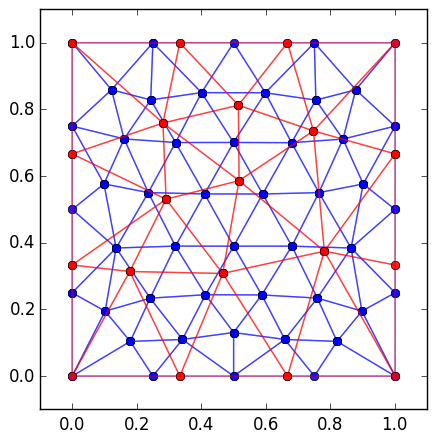

(-0.1,1.1)

In [4]:
using JuliaFEM.Core: Element, MortarProblem, calculate_normal_tangential_coordinates!

using PyPlot

#mortar_surface = :LOWER_TO_UPPER
#slave_surface = :UPPER_TO_LOWER
mortar_surface = :UPPER_TO_LOWER
slave_surface = :LOWER_TO_UPPER

fig1 = figure(figsize=(5, 5))
master_elements = JuliaFEM.Core.Element[]
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :TR3) && (elset == mortar_surface) || continue
    element = Tri3(elcon)
    update(element, "geometry", mesh["nodes"])
    X = element("geometry", 0.0)
    x = [X[mod(i, 3)+1][1] for i=1:4]
    y = [X[mod(i, 3)+1][2] for i=1:4]
    plot(x, y, "-bo", alpha=0.5)
    push!(master_elements, element)
end

contact_problem = MortarProblem("displacement", 3)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :TR3) && (elset == slave_surface) || continue
    element = Tri3(reverse(elcon))
    update(element, "geometry", mesh["nodes"])
    element["master elements"] = master_elements
    X = element("geometry", 0.0)
    x = [X[mod(i, 3)+1][1] for i=1:4]
    y = [X[mod(i, 3)+1][2] for i=1:4]
    plot(x, y, "-ro", alpha=0.5)
    calculate_normal_tangential_coordinates!(element, 0.0)
    push!(contact_problem, element)
end
xlim(-0.1, 1.1)
ylim(-0.1, 1.1)

In [5]:
using JuliaFEM.Core: DirectSolver
solver = DirectSolver()
solver.name = "tie_contact_3d"
solver.method = :UMFPACK
solver.nonlinear_problem = false
solver.max_iterations = 1
solver.dump_matrices = true
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, contact_problem)
call(solver, 0.0)

using JuliaFEM.Test

nid = 0
for (nid, coords) in mesh["nodes"]
    if isapprox(coords, [1.0, 1.0, 1.0])
        info("nid near corner = $nid")
        break
    end
end
nid

known_value = [1/36, 1/36, -1/9]

for element in field_problem.elements
    i = indexin([nid], get_connectivity(element))[1]
    i != 0 || continue
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    info("displacement X = $(X[i]), u = $(u[i])")
    @test isapprox(u[i], known_value, atol=1.0e-5)
end

INFO: # of field problems: 1
INFO: # of boundary problems: 2
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1...
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: dim = 807
INFO: Assembling boundary problems...
INFO: Assembling boundary 1...
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: Assembling boundary 2...
INFO: dumping matrices to disk, file = matrices_tie_contact_3d_host_1_iteration_1.jld
INFO: Solving system
INFO: UMFPACK: solved in 

In [6]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []
for el in field_problem.elements
    isa(el, JuliaFEM.Core.Element{JuliaFEM.Core.Tet4}) || continue
    push!(elements, (:Tet4, get_connectivity(el)))
end
#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/blocks_tet4.xmf");

INFO: XDFM: ndim = 807


<img src="http://results.juliafem.org/divided-block-tet4/2015-12-17-tet4-results.png"
         style="width:80%; height:auto; vertical-align:middle;">

## Several contacts with shared nodes

In [1]:
using JuliaFEM
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: LinearElasticityProblem, DirichletProblem, get_connectivity, Tri3, Tet4, LinearSolver, update
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/unit_box/SUPERBLOCK.med")

INFO: Found 12 element sets: BLOCK4_TO_BLOCK3, SYM12, SYM23, BLOCK4_TO_BLOCK2, BLOCK3_TO_BLOCK4, BLOCK1_TO_BLOCK3, SYM13, LOAD, BLOCK1_TO_BLOCK2, BLOCK2_TO_BLOCK4, BLOCK2_TO_BLOCK1, BLOCK3_TO_BLOCK1


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(306=>[0.0,0.8469606634303125,0.4191161978569679],29=>[…
  "connectivity" => Dict(2843=>(:TE4,:OTHER,[631,574,595,513]),1316=>(:TR3,:SYM…

In [2]:
# interior elements are of type HE8
field_problem = LinearElasticityProblem()

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :TE4 || continue
    element = Tet4(elcon)
    update(element, "geometry", mesh["nodes"])
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    #info("lower: add element with connectivity $elcon")
    push!(field_problem, element)
end

# Neumann boundary condition, traction force -100 on Z direction for element set LOAD
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :TR3) && (elset == :LOAD) || continue
    element = Tri3(elcon)
    update(element, "geometry", mesh["nodes"])
    element["displacement traction force 3"] = -100.0
    push!(field_problem, element)
end
info("created $(length(field_problem.elements)) elements.")

# boundary conditions
boundary_problem = DirichletProblem("displacement", 3)

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    (eltype == :TR3) && (elset in [:SYM23, :SYM12, :SYM13]) || continue
    element = Tri3(elcon)
    update(element, "geometry", mesh["nodes"])
    if elset == :SYM23
        element["displacement 1"] = 0.0
    elseif elset == :SYM12
        element["displacement 3"] = 0.0
    elseif elset == :SYM13
        element["displacement 2"] = 0.0
    end
    push!(boundary_problem, element)
end
info("created $(length(boundary_problem.elements)) boundary elements.")

INFO: created 2878 elements.
INFO: created 403 boundary elements.


Contact pairs: BLOCK1 <-> BLOCK3, BLOCK1 <-> BLOCK2, BLOCK2 <-> BLOCK4, BLOCK3 <-> BLOCK4

In [3]:
using JuliaFEM.Core: Element, MortarProblem, calculate_normal_tangential_coordinates!

function create_contact(master_surface, slave_surface)

    master_elements = JuliaFEM.Core.Element[]
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        (eltype == :TR3) && (elset == master_surface) || continue
        element = Tri3(elcon)
        update(element, "geometry", mesh["nodes"])
        push!(master_elements, element)
    end

    contact_problem = MortarProblem("displacement", 3)
    for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
        (eltype == :TR3) && (elset == slave_surface) || continue
        element = Tri3(reverse(elcon))
        update(element, "geometry", mesh["nodes"])
        element["master elements"] = master_elements
        calculate_normal_tangential_coordinates!(element, 0.0)
        push!(contact_problem, element)
    end

    return contact_problem
end

tie1 = create_contact(:BLOCK1_TO_BLOCK3, :BLOCK3_TO_BLOCK1)
tie2 = create_contact(:BLOCK1_TO_BLOCK2, :BLOCK2_TO_BLOCK1)
tie3 = create_contact(:BLOCK2_TO_BLOCK4, :BLOCK4_TO_BLOCK2)
tie4 = create_contact(:BLOCK3_TO_BLOCK4, :BLOCK4_TO_BLOCK3);

In [4]:
using JuliaFEM.Core: DirectSolver
solver = DirectSolver()
solver.name = "tie_contact_3d"
solver.method = :UMFPACK
solver.nonlinear_problem = false
solver.max_iterations = 1
solver.dump_matrices = true
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, tie1, tie2, tie3, tie4)
call(solver, 0.0)

using JuliaFEM.Test

nid = 0
for (nid, coords) in mesh["nodes"]
    if isapprox(coords, [1.0, 1.0, 1.0])
        info("nid near corner = $nid")
        break
    end
end
nid

known_value = [1/36, 1/36, -1/9]

for element in field_problem.elements
    i = indexin([nid], get_connectivity(element))[1]
    i != 0 || continue
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    info("displacement X = $(X[i]), u = $(u[i])")
    @test isapprox(u[i], known_value, atol=1.0e-3)
end

INFO: # of field problems: 1
INFO: # of boundary problems: 5
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1...
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: dim = 2562
INFO: Assembling boundary problems...
INFO: Assembling boundary 1...
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: Assembling boundary 2...
INFO: Assembling boundary 3...
INFO: Assembling boundary 4...
INFO: Assembling boundary 5...
INFO: dumping matrices to disk, file =

In [5]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []
for el in field_problem.elements
    isa(el, JuliaFEM.Core.Element{JuliaFEM.Core.Tet4}) || continue
    push!(elements, (:Tet4, get_connectivity(el)))
end
#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/superblock.xmf");

INFO: XDFM: ndim = 2562


<img src="http://results.juliafem.org/2015-12-17-superblock.png"
         style="width:80%; height:auto; vertical-align:middle;">